# 2019 Data Science Bowl
## A Simple Introduction

tl;dr

*In this challenge, you’ll use anonymous gameplay data, including knowledge of videos watched and games played, from the PBS KIDS Measure Up! app, a game-based learning tool developed as a part of the CPB-PBS Ready To Learn Initiative with funding from the U.S. Department of Education. Competitors will be challenged to predict scores on in-game assessments and create an algorithm that will lead to better-designed games and improved learning outcomes. *

**
Note that this is a synchronous rerun code competition and the private test set has approximately 8MM rows. You should be mindful of memory in your notebooks to avoid submission errors.** 😅

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from IPython.display import HTML
import warnings
pd.set_option('max_columns', 100)
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
my_pal = sns.color_palette(n_colors=10)

First we will see what files we are given to work with. Note the `train.csv` file is quite large at 3.7G.
From the data description we know:
- `train.csv` & `test.csv` : These are the main data files which contain the gameplay events.
- `specs.csv` : This file gives the specification of the various event types.
- `train_labels.csv` : This file demonstrates how to compute the ground truth for the assessments in the training set.
- `sample_submission.csv` : A sample submission in the correct format.

In [2]:
!ls -GFlash ../input/data-science-bowl-2019/

total 4.0G
4.0K drwxr-xr-x 2 root 4.0K Oct 23 16:22 ./
4.0K drwxr-xr-x 3 root 4.0K Oct 26 04:05 ../
 12K -rw-r--r-- 1 root  11K Oct 23 16:21 sample_submission.csv
400K -rw-r--r-- 1 root 400K Oct 23 16:21 specs.csv
380M -rw-r--r-- 1 root 380M Oct 23 16:22 test.csv
3.7G -rw-r--r-- 1 root 3.7G Oct 23 16:22 train.csv
1.1M -rw-r--r-- 1 root 1.1M Oct 23 16:21 train_labels.csv


In [3]:
# Read in the data CSV files
train = pd.read_csv('../input/data-science-bowl-2019/train.csv')
train_labels = pd.read_csv('../input/data-science-bowl-2019/train_labels.csv')
test = pd.read_csv('../input/data-science-bowl-2019/test.csv')
specs = pd.read_csv('../input/data-science-bowl-2019/specs.csv')
ss = pd.read_csv('../input/data-science-bowl-2019/sample_submission.csv')

Because the training data is so large, we will take a random sample of it for plotting. Since we are doing this at random it will speed up the time it takes to plot, and should still give us a a good view of the data's format.

In [4]:
train_ = train.sample(1000000) #sample 1M observations

## The target.
First we will look at the target we intend to predict.

We are told: *The intent of the competition is to use the gameplay data to forecast how many attempts a child will take to pass a given assessment (an incorrect answer is counted as an attempt).*
The outcomes in this competition are grouped into 4 groups (labeled accuracy_group in the data):
- 3: the assessment was solved on the first attempt
- 2: the assessment was solved on the second attempt
- 1: the assessment was solved after 3 or more attempts
- 0: the assessment was never solved


In [5]:
train_labels.head()

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


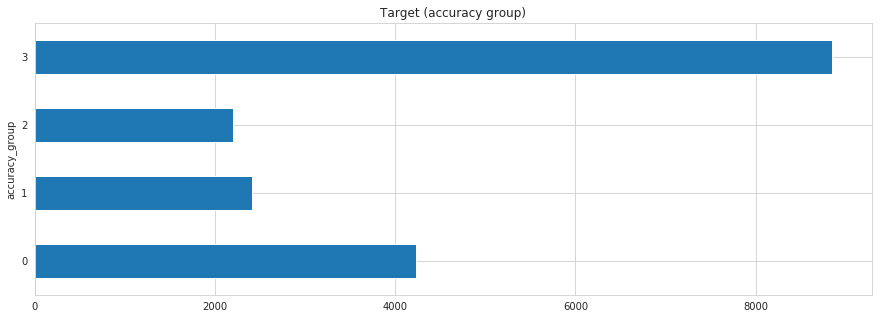

In [6]:
train_labels.groupby('accuracy_group')['game_session'].count() \
    .plot(kind='barh', figsize=(15, 5), title='Target (accuracy group)')
plt.show()

Thngs to note about the taget:
- Accuracy of 100% goes to group 3
- Accuracy of ~50% goes to group 2
- Not finishing goes to group 0
- Group 1 looks to have the most variation

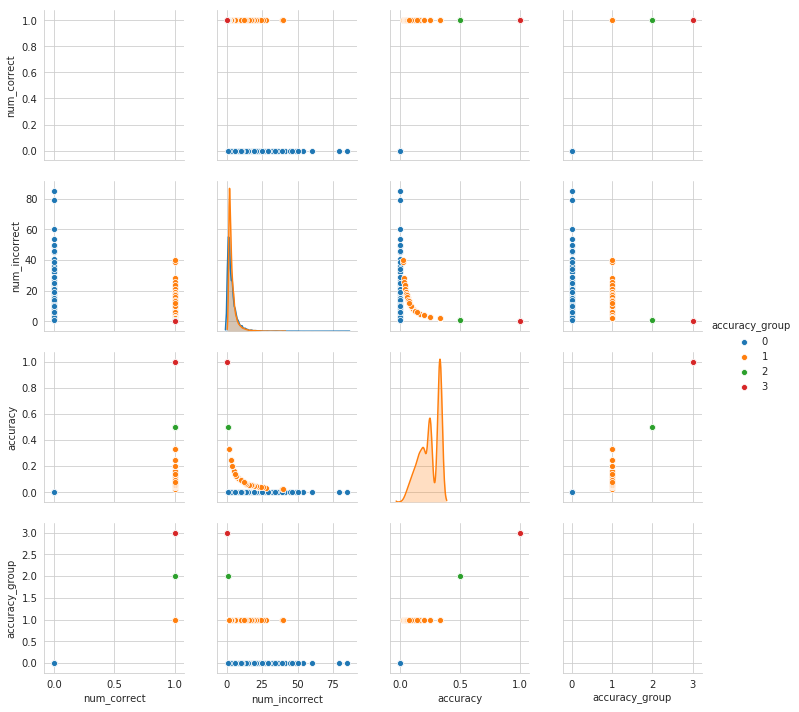

In [7]:
sns.pairplot(train_labels, hue='accuracy_group')
plt.show()

# train.csv / test.csv
The data provided in these files are as follows:
- `event_id` - Randomly generated unique identifier for the event type. Maps to event_id column in specs table.
- `game_session` - Randomly generated unique identifier grouping events within a single game or video play session.
- `timestamp` - Client-generated datetime
- `event_data` - Semi-structured JSON formatted string containing the events parameters. Default fields are: event_count, event_code, and game_time; otherwise - fields are determined by the event type.
- `installation_id` - Randomly generated unique identifier grouping game sessions within a single installed application instance.
- `event_count` - Incremental counter of events within a game session (offset at 1). Extracted from event_data.
- `event_code` - Identifier of the event 'class'. Unique per game, but may be duplicated across games. E.g. event code '2000' always identifies the 'Start Game' event for all games. Extracted from event_data.
- `game_time` - Time in milliseconds since the start of the game session. Extracted from event_data.
- `title` - Title of the game or video.
- `type` - Media type of the game or video. Possible values are: 'Game', 'Assessment', 'Activity', 'Clip'.
- `world` - The section of the application the game or video belongs to. Helpful to identify the educational curriculum goals of the media. Possible values are: 'NONE' (at the app's start screen), TREETOPCITY' (Length/Height), 'MAGMAPEAK' (Capacity/Displacement), 'CRYSTALCAVES' (Weight).

In [8]:
train.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


## event_id & game_session
They say it's randomly generated, but is that true? Looks to be hex, lets convert it to an integer. Plotting shows nothign really interesting.

In [9]:
train['event_id_as_int'] = train['event_id'].apply(lambda x: int(x, 16))
train['game_session_as_int'] = train['game_session'].apply(lambda x: int(x, 16))

## timestamp
Lets see how many observations we have over time. Are they all in the same/similar time zone?
- Looks like number of observations rises over time. Steep pickup and dropoff at the start/end
- Much less use during the middle of the night hours. Use increases during the day with a slow reduction in use around midnight. We don't know how the timestamp relates to time zones for different users.
- More users on Thursday and Friday. 

In [10]:
# Format and make date / hour features
train['timestamp'] = pd.to_datetime(train['timestamp'])
train['date'] = train['timestamp'].dt.date
train['hour'] = train['timestamp'].dt.hour
train['weekday_name'] = train['timestamp'].dt.weekday_name
# Same for test
test['timestamp'] = pd.to_datetime(test['timestamp'])
test['date'] = test['timestamp'].dt.date
test['hour'] = test['timestamp'].dt.hour
test['weekday_name'] = test['timestamp'].dt.weekday_name

In [11]:
print(f'Train data has shape: {train.shape}')
print(f'Test data has shape: {test.shape}')

Train data has shape: (11341042, 16)
Test data has shape: (1156414, 14)


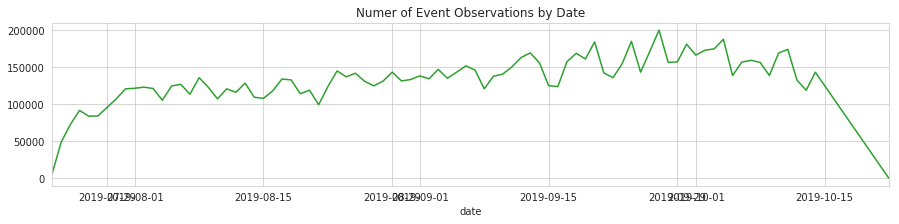

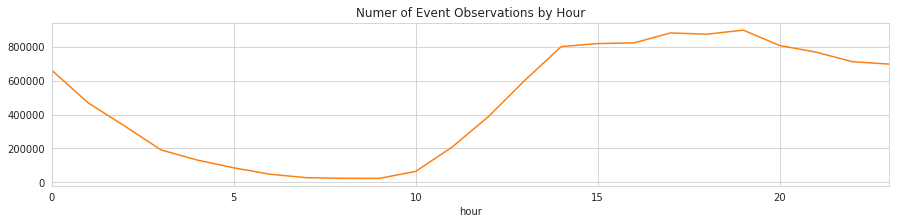

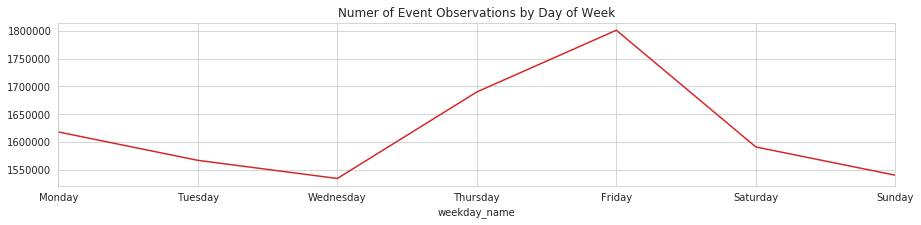

In [12]:
train.groupby('date')['event_id'] \
    .agg('count') \
    .plot(figsize=(15, 3),
         title='Numer of Event Observations by Date',
         color=my_pal[2])
plt.show()
train.groupby('hour')['event_id'] \
    .agg('count') \
    .plot(figsize=(15, 3),
         title='Numer of Event Observations by Hour',
         color=my_pal[1])
plt.show()
train.groupby('weekday_name')['event_id'] \
    .agg('count').T[['Monday','Tuesday','Wednesday',
                     'Thursday','Friday','Saturday',
                     'Sunday']].T.plot(figsize=(15, 3),
                                       title='Numer of Event Observations by Day of Week',
                                       color=my_pal[3])
plt.show()

# event_data
This looks to have most of the interesting data about the event. It is in JSON format which isn't easy to wrangle in a tabular way. We need to be clever when parsing this data. They have already parsed some of this data for us like `event_count` and `event_code`.

In [13]:
print(train['event_data'][4])
print(train['event_data'][5])

{"description":"Let's build a sandcastle! First, fill up your mold with sand! You can use the shovel here. The mold gives the sand its shape!","identifier":"Dot_LetsSandcastle,Dot_FillMold,Dot_MoldShape","media_type":"audio","duration":6919,"event_count":3,"game_time":6972,"event_code":3110}
{"coordinates":{"x":583,"y":605,"stage_width":1015,"stage_height":762},"event_count":4,"game_time":9991,"event_code":4070}


## installation_id *important - predictions are grouped by these*
- Randomly generated unique identifier grouping game sessions within a single installed application instance.
- We will be predicting based off of these IDs
- The training set has exactly 17000 unique `installation_ids`

In [14]:
train['installation_id'].nunique()

17000

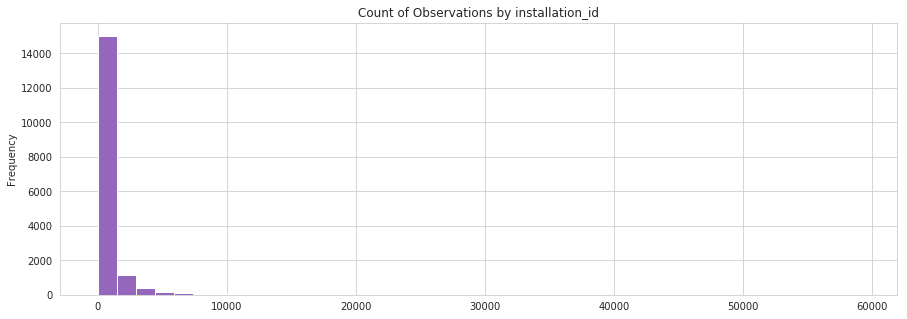

In [15]:
train.groupby('installation_id') \
    .count()['event_id'] \
    .plot(kind='hist',
          bins=40,
          color=my_pal[4],
          figsize=(15, 5),
         title='Count of Observations by installation_id')
plt.show()

Lets take a log transform of this count to we can more easily see what the distribution of counts by `insallation_id` looks like

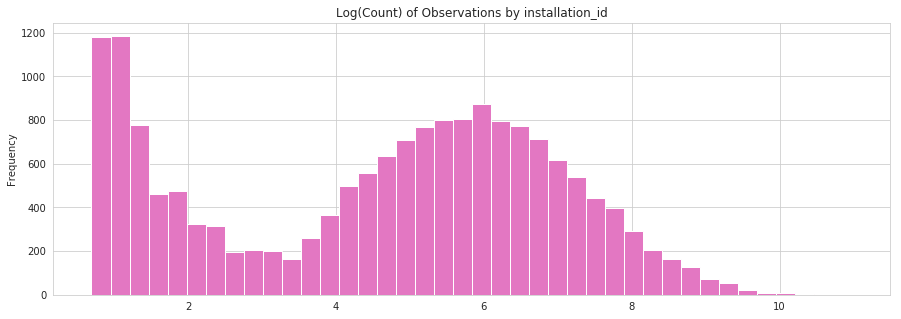

In [16]:
train.groupby('installation_id') \
    .count()['event_id'] \
    .apply(np.log1p) \
    .plot(kind='hist',
          bins=40,
          color=my_pal[6],
         figsize=(15, 5),
         title='Log(Count) of Observations by installation_id')
plt.show()

Lets looks at some of the installation_ids with the highest counts. We see some installation_ids have tens of thousands of observations!

In [17]:
train.groupby('installation_id') \
    .count()['event_id'].sort_values(ascending=False).head(5)

installation_id
f1c21eda    58988
4d7d3d97    32749
d25338cb    31826
cff5a334    30918
c9ea32e9    30402
Name: event_id, dtype: int64

Wow, 50000+ events for a single `installation_id`. Lets take a closer look at the id with the most observations. Not exactly sure what I'm looking at here. But it looks like this `installation_id` spans a long duration (over one month). Could this be installed by a bot? The use history does not look natural.

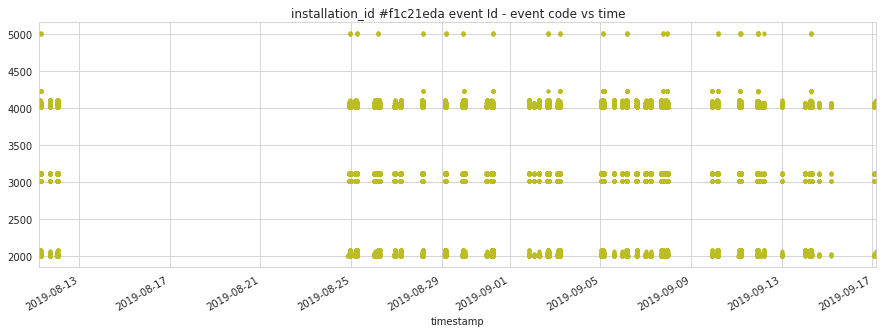

In [18]:
train.query('installation_id == "f1c21eda"') \
    .set_index('timestamp')['event_code'] \
    .plot(figsize=(15, 5),
          title='installation_id #f1c21eda event Id - event code vs time',
         style='.',
         color=my_pal[8])
plt.show()

## event_code
- Identifier of the event 'class'. Unique per game, but may be duplicated across games. E.g. event code '2000' always identifies the 'Start Game' event for all games. Extracted from event_data.

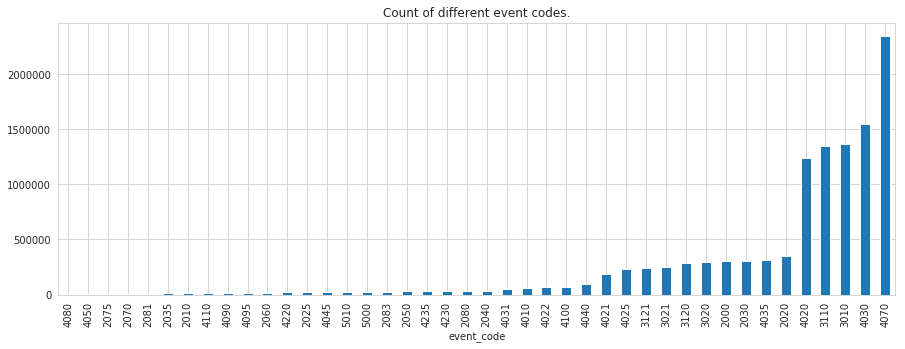

In [19]:
train.groupby('event_code') \
    .count()['event_id'] \
    .sort_values() \
    .plot(kind='bar',
         figsize=(15, 5),
         title='Count of different event codes.')
plt.show()

lets take a closer look at the event codes `4070` and `4030`
- We notice that event 4070 and 4030 always comes with coordinates (x, y) and stage_width.
- Possibly they could be marking acheivements or something related to position on the screen.
These events look like this:
```
{"size":0,"coordinates":{"x":782,"y":207,"stage_width":1015,"stage_height":762},"event_count":55,"game_time":34324,"event_code":4030}
```

## game_time
- Time in milliseconds since the start of the game session. Extracted from event_data.
- The `log1p` transform shows a somewhat normal distribution with a peak at zero.

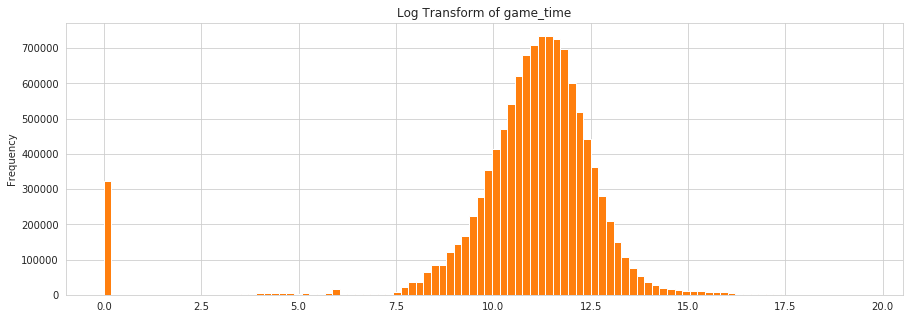

In [20]:
train['game_time'].apply(np.log1p) \
    .plot(kind='hist',
          figsize=(15, 5),
          bins=100,
          title='Log Transform of game_time',
          color=my_pal[1])
plt.show()

## Game/Video titles
- Chow Time is very popular, along with Sandcastle Builder, Scrub-A-Dub, and Bottle Filler
- After that there is a steep dropoff
- Assessment's are in the 200000 count range.
- Games with levels are less frequent
- Some games or titles (maybe videos?) at the bottom are very infrequently seen.

Some examples of the top games:
Chow Time:
https://www.youtube.com/watch?v=tvRtFqOqa-Y



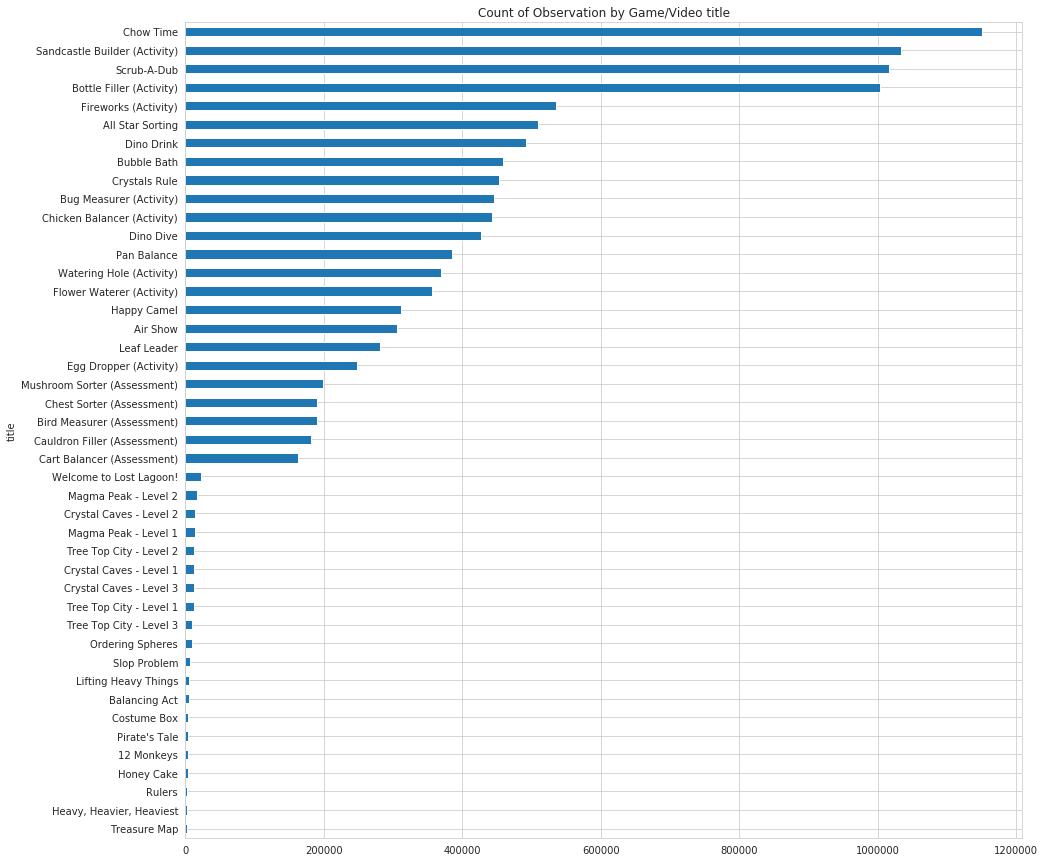

In [21]:
train.groupby('title')['event_id'] \
    .count() \
    .sort_values() \
    .plot(kind='barh',
          title='Count of Observation by Game/Video title',
         figsize=(15, 15))
plt.show()

## Video Examples of the Gameplay
Its helpful to see what the games actually look like. Here are a few youtube videos showing gameplay of the more popular titles.

In [22]:
# Chow Time Video
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/tvRtFqOqa-Y" frameborder="0" allow="accelerometer; \
        autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

In [23]:
# Scrub-a-Dub
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/kkNzO2QzWaQ" frameborder="0" allow="accelerometer; \
    autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

## Game/Video type
- Media type of the game or video. Possible values are: 'Game', 'Assessment', 'Activity', 'Clip'.
- Most are games, next are activities
- Clips are the least common

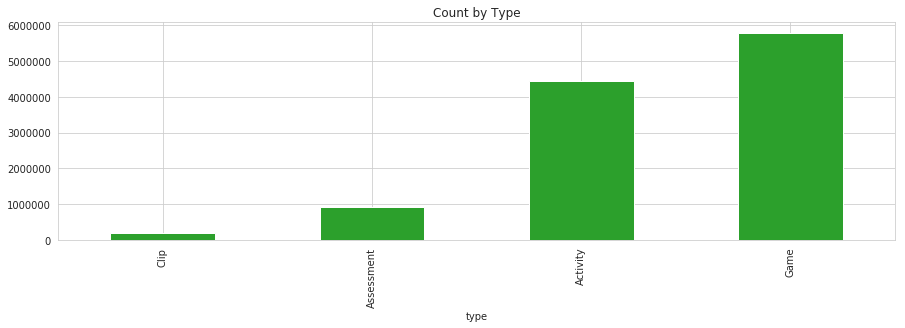

In [24]:
train.groupby('type')['event_id'] \
    .count() \
    .sort_values() \
    .plot(kind='bar',
          figsize=(15, 4),
          title='Count by Type',
          color=my_pal[2])
plt.show()

## World
- The section of the application the game or video belongs to. Helpful to identify the educational curriculum goals of the media.
- Possible values are: 'NONE' (at the app's start screen), TREETOPCITY' (Length/Height), 'MAGMAPEAK' (Capacity/Displacement), 'CRYSTALCAVES' (Weight).

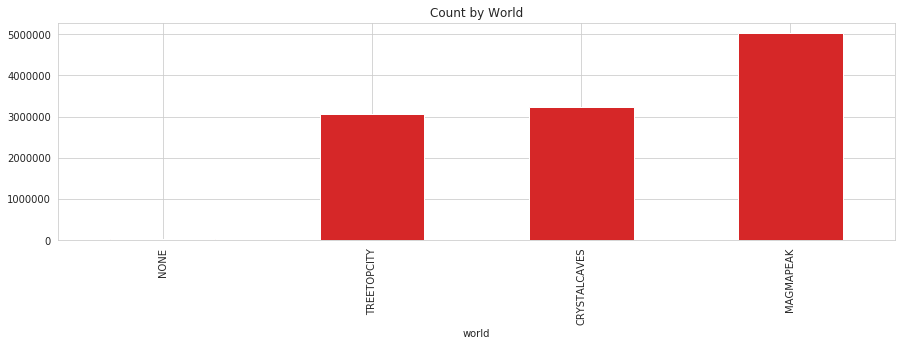

In [25]:
train.groupby('world')['event_id'] \
    .count() \
    .sort_values() \
    .plot(kind='bar',
          figsize=(15, 4),
          title='Count by World',
          color=my_pal[3])
plt.show()

## log(game_time) vs game/video categories 

In [26]:
train['log1p_game_time'] = train['game_time'].apply(np.log1p)

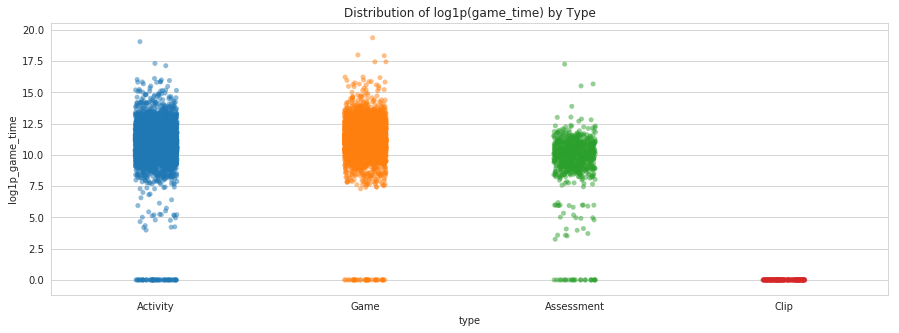

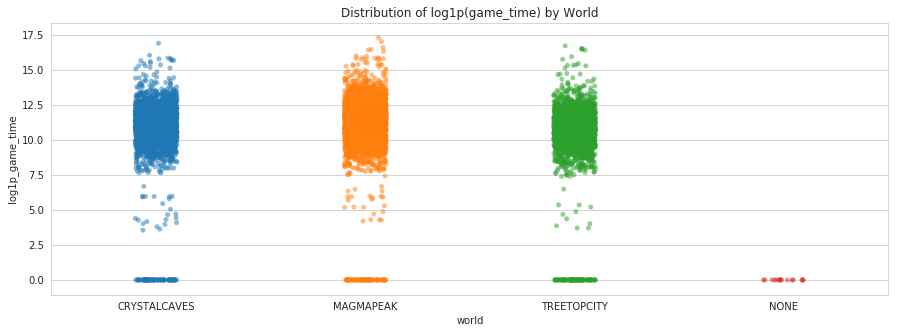

In [27]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.catplot(x="type", y="log1p_game_time",
            data=train.sample(10000), alpha=0.5, ax=ax);
ax.set_title('Distribution of log1p(game_time) by Type')
plt.close()
plt.show()
fig, ax = plt.subplots(figsize=(15, 5))
sns.catplot(x="world", y="log1p_game_time",
            data=train.sample(10000), alpha=0.5, ax=ax);
ax.set_title('Distribution of log1p(game_time) by World')
plt.close()
plt.show()

# specs.csv
The `specs.csv` gives us more information about what the event ids represent.
- There are 386 unique event_ids
- 168 unique info
- 191 unique args
- info and args columns

In [28]:
specs.head()

,event_id,info,args
0,2b9272f4,The end of system-initiated feedback (Correct)...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
1,df4fe8b6,The end of system-initiated feedback (Incorrec...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
2,3babcb9b,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
3,7f0836bf,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
4,ab3136ba,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."


In [29]:
specs.describe()

,event_id,info,args
count,386,386,386
unique,386,168,191
top,3d63345e,This event occurs when the player clicks on th...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
freq,1,17,25


# Baseline Model

We are told in the data description that:
- The file train_labels.csv has been provided to show how these groups would be computed on the assessments in the training set.
- Assessment attempts are captured in event_code 4100 for all assessments except for Bird Measurer, which uses event_code 4110. 
- If the attempt was correct, it contains "correct":true.

We also know:
- The intent of the competition is to **use the gameplay data to forecast how many attempts a child will take to pass a given assessment** (an incorrect answer is counted as an attempt). 
- Each application install is represented by an installation_id. This will typically correspond to one child, but you should expect noise from issues such as shared devices.
- **In the training set, you are provided the full history of gameplay data.**
- In the test set, we have truncated the history after the start event of a single assessment, chosen randomly, for which you must predict the number of attempts.
- Note that the training set contains many installation_ids which never took assessments, whereas every installation_id in the test set made an attempt on at least one assessment.

In [30]:
# First Attempt... still working to fully understand the problem
from sklearn.model_selection import train_test_split

# Define cleared or not cleared
# 
train['cleared'] = True
train.loc[train['event_data'].str.contains('false') & train['event_code'].isin([4100, 4110]), 'cleared'] = False

test['cleared'] = True
test.loc[test['event_data'].str.contains('false') & test['event_code'].isin([4100, 4110]), 'cleared'] = False

aggs = {'hour': ['max','min','mean'],
        'cleared': ['mean']}

train_aggs = train.groupby('installation_id').agg(aggs)
test_aggs = test.groupby('installation_id').agg(aggs)
train_aggs = train_aggs.reset_index()
test_aggs = test_aggs.reset_index()
train_aggs.columns = ['_'.join(col).strip() for col in train_aggs.columns.values]
test_aggs.columns = ['_'.join(col).strip() for col in test_aggs.columns.values]
train_aggs = train_aggs.rename(columns={'installation_id_' : 'installation_id'})

In [31]:
# Hmmm... not 1:1
train_aggs.merge(train_labels[['installation_id','accuracy_group']],
                 how='left')

,installation_id,hour_max,hour_min,hour_mean,cleared_mean,accuracy_group
0,0001e90f,18,17,17.733235,1.000000,NaN
1,000447c4,15,14,14.690608,1.000000,NaN
2,0006a69f,20,4,11.927124,0.995527,3.0
3,0006a69f,20,4,11.927124,0.995527,0.0
4,0006a69f,20,4,11.927124,0.995527,3.0
...,...,...,...,...,...,...
31071,fff64664,18,13,15.277279,1.000000,NaN
31072,fff70c1e,9,8,8.068182,1.000000,NaN
31073,fff744ce,21,21,21.000000,1.000000,NaN
31074,fff944d5,21,21,21.000000,1.000000,NaN
